In [ ]:
# Tratamiento de datos
# SE IMPORTAN LAS LIBRERIAS NECESARIAS 
# ==============================================================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
from plotnine import *
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge

import multiprocessing
import random
from itertools import product
import time

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score


from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split


In [ ]:
# SE CREA LA FUNCION ELIMINAR_COLUMNA PARA ELIMINAR COLUMNAS (VARIABLES) EN EL FUTURO
def eliminar_columna(nombre_columna):
    datos.drop(nombre_columna, axis=1, inplace=True) #se edita df principal

In [ ]:
start = time.time()

In [ ]:
# SE CREA EL NOMBRE ARCHIVO QUE SERA UN APODO PARA LA BBDD QUE TENEMOS COMO ENTRENAMIENTO
archivo='ALUMNOS-trainData.csv'

In [ ]:
# SE LEE EL ARCHIVO CSV Y SE ALMACENA EN LA VARIABLES DATOS
datos=pd.read_csv(archivo)

In [ ]:
#LEYENDO LOS PRIMEROS DATOS DE LA VARIABLE DATOS 
datos.head()

,Unnamed: 0,date,fligth_number,origin,destination,distance,noshow,denied_boarding,pax_midlow,pax_high,...,pax_freqflyer,group_bookings,out_of_stock,dom_cnx,int_cnx,p2p,departure_time,capacity,revenues_usd,bookings
0,389083,2009-11-09,8995,BBA,SCL,1394,9.0,0,94,2,...,22,19,0,1,0,239,10:30:00,174.0,10631.1,240
1,177073,2009-05-23,7061,LIM,TRU,489,0.0,0,100,4,...,25,0,0,19,9,192,19:20:00,174.0,5453.7,220
2,1040357,2011-05-09,8972,SCL,PUQ,2180,4.0,0,7,1,...,2,0,0,0,10,69,09:54:00,218.0,16161.0,79
3,505258,2010-02-12,6039,CGH,CNF,524,13.0,0,54,4,...,4,0,0,26,0,64,21:00:00,174.0,10828.7,90
4,369663,2009-10-24,7713,GPS,GYE,1170,14.0,0,21,88,...,0,88,1,23,3,183,12:40:00,144.0,16721.6,209


In [ ]:
# NOS DIMOS CUENTA QUE LA VARIABLE NOSHOW NO ESTA BINARIZADA, SINO QUE ES UN ENTERO, LO QUE DEBEMOS HACER ES BINARIZARLA Y LUEGO CREAMOS OTRA VARIABLE BINARIZADA PERO AHORA SE LLAMA NOSHOW_B
datos['noshow_b'] = np.where(datos['noshow'] >= 4, 1,0)

In [ ]:
#TRABAJAMOS CON EL 50% DE LA BBDD CON EL FIN DE HACER LOS PROCESOS MAS CORTOS de analisis explotario
datos = datos.sample(frac=0.2)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

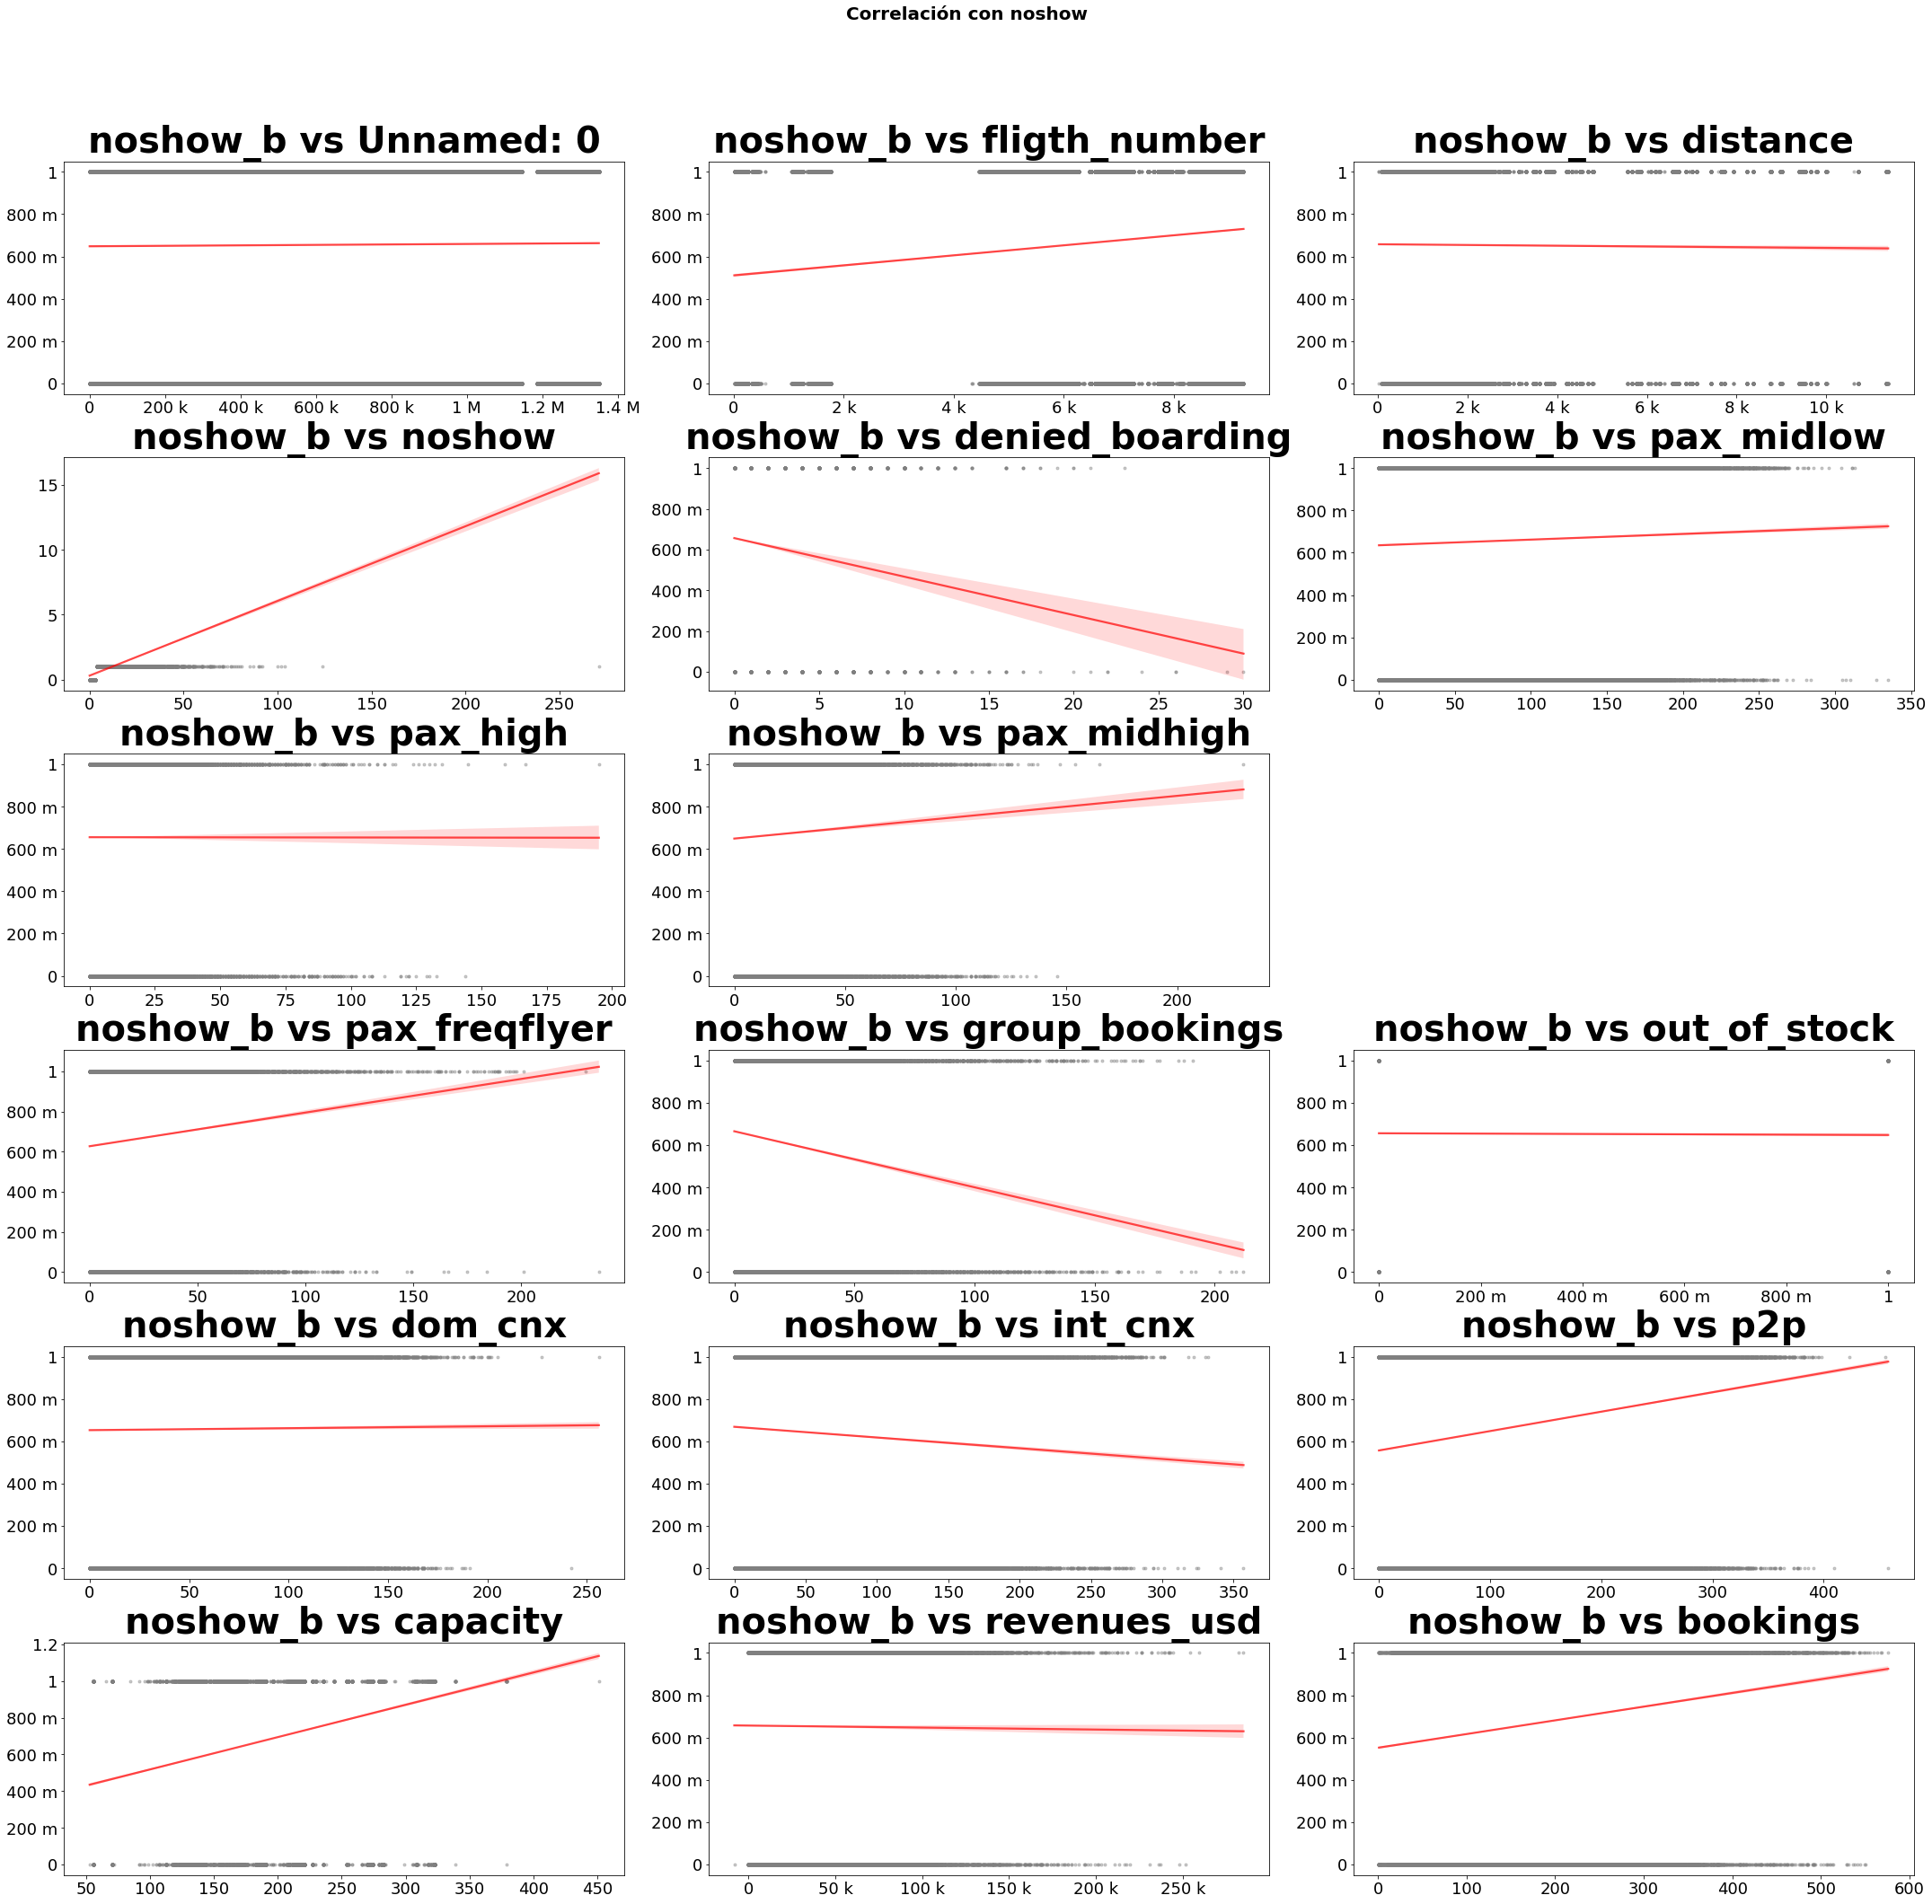

In [ ]:
# GRAFICAMOS LAS CORRELACIONES QUE EXISTEN ENTRE LAS VARIABLES, CON EL FIN DE IDENTIFICAR VARIABLES QUE NO TIENEN RELACION CON NOSHOW_B

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(30, 30))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('noshow_b')
k=0

for i, colum in enumerate(columnas_numeric):
    k=k+1
    sns.regplot(
        x           = datos[colum],
        y           = datos['noshow_b'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"noshow_b vs {colum}", fontsize = 40,color='black', fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 18)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    print(k,"",end="")
# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con noshow\n', fontsize = 20,color='black', fontweight = "bold");

In [ ]:
#elimino primera columna ya que no se conoce su significado
datos.drop(columns=datos.columns[0], axis=1, inplace=True)

In [ ]:
# SE ELIMINAN VARIABLES COMO FLIGHT_NUMBER DADO QUE ES COMO UN ID, OUT_OF STOCK
eliminar=['fligth_number','out_of_stock','date','departure_time','noshow']
for i in eliminar:
    eliminar_columna(i)

In [ ]:
# SE OBSERVA COMO VA QUEDANDO LA BBDD 
datos.head(2)

,origin,destination,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,noshow_b
784310,SDU,CGH,366,0,57,10,1,25,35,0,63,0,65,144.0,8409.9,128,0
228501,BAQ,BOG,692,0,8,0,0,125,12,6,2,2,141,144.0,4787.6,145,1


In [ ]:
#se revisa que los datos no tengan na y no existan datos que se repitan dado que pueden provocar sesgo en el entrenamiento del modelo
print(datos.shape)
print(datos.isna().sum())
print("Numeros de datos duplicado:",datos.duplicated().sum())

#se encuntra un dato elimando y se procede
datos = datos.drop_duplicates()

print("Numero de datos duplicados:",datos.duplicated().sum())
print(datos.shape)

(199978, 17)
origin             0
destination        0
distance           0
denied_boarding    0
pax_midlow         0
pax_high           0
pax_midhigh        0
pax_low            0
pax_freqflyer      0
group_bookings     0
dom_cnx            0
int_cnx            0
p2p                0
capacity           0
revenues_usd       0
bookings           0
noshow_b           0
dtype: int64
Numeros de datos duplicado: 0
Numero de datos duplicados: 0
(199978, 17)


In [ ]:
#SE DESPLIEGA EL TIPO DE DATO QUE ES CADA VARIABLE, DADO QUE SE BUSCA TRABAJAR CON VARIABLES NUMERICAS 
datos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199978 entries, 784310 to 791278
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   origin           199978 non-null  object 
 1   destination      199978 non-null  object 
 2   distance         199978 non-null  int64  
 3   denied_boarding  199978 non-null  int64  
 4   pax_midlow       199978 non-null  int64  
 5   pax_high         199978 non-null  int64  
 6   pax_midhigh      199978 non-null  int64  
 7   pax_low          199978 non-null  int64  
 8   pax_freqflyer    199978 non-null  int64  
 9   group_bookings   199978 non-null  int64  
 10  dom_cnx          199978 non-null  int64  
 11  int_cnx          199978 non-null  int64  
 12  p2p              199978 non-null  int64  
 13  capacity         199978 non-null  float64
 14  revenues_usd     199978 non-null  float64
 15  bookings         199978 non-null  int64  
 16  noshow_b         199978 non-null 

In [ ]:
# SE VERIFICAN CON QUE VARIABLES SE TRABAJARA FINALMENTE
datos.columns.values

array(['distance', 'denied_boarding', 'pax_midlow', 'pax_high',
       'pax_midhigh', 'pax_low', 'pax_freqflyer', 'group_bookings',
       'dom_cnx', 'int_cnx', 'p2p', 'capacity', 'revenues_usd',
       'bookings', 'noshow_b'], dtype=object)

In [ ]:
#Entrena el modelo PCA con escalado de los datos

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline 

pca_pipe = make_pipeline(StandardScaler(),PCA(n_components=2))
pca_pipe.fit(datos)

#se extrae el modelo entrenado del pipelie
modelo_pca = pca_pipe.named_steps['pca']

In [ ]:
# Proyección de las observaciones de entrenamiento
# ==============================================================================
proyecciones = pca_pipe.transform(X=datos)
proyecciones = pd.DataFrame(
    proyecciones,
    columns = ['PC1', 'PC2'],
    index   = datos.index
)
proyecciones.head()

,PC1,PC2
784310,-1.636940,0.548663
228501,-0.913732,-1.773035
883834,0.133382,-0.949598
439886,0.434670,-0.035782
901497,1.461298,1.146725


In [ ]:
# SE CREA UN DATAFRAME CON LOS 2 COMPOENTES A GARFICAR "PC1 Y PC2"
pd.DataFrame(
    data = modelo_pca.components_,
    columns = datos.columns,
    index = ['PC1','PC2']
)

,distance,denied_boarding,pax_midlow,pax_high,pax_midhigh,pax_low,pax_freqflyer,group_bookings,dom_cnx,int_cnx,p2p,capacity,revenues_usd,bookings,noshow_b
PC1,0.357507,0.006471,0.369634,0.043697,0.019033,0.264267,0.163950,0.078629,-0.100748,0.313222,0.289047,0.349265,0.361145,0.429141,0.044348
PC2,0.295270,0.013008,-0.119867,0.284065,0.224186,-0.443349,0.065914,0.088611,-0.029844,0.338974,-0.473616,0.086710,0.363807,-0.249049,-0.128706


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

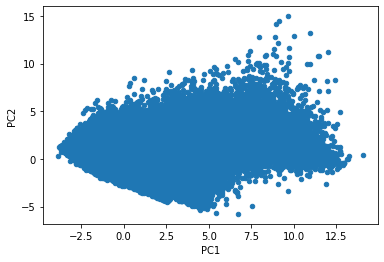

In [ ]:
# SE  GRAFICAN LOS DATOS EN 2 COMPONENTES
proyecciones.plot(x ='PC1', y='PC2', kind = 'scatter')

In [ ]:
# SE DESPLIEGA INFO RELEVANTE DE LOS 2 COMPONENTES 
proyecciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199978 entries, 784310 to 791278
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PC1     199978 non-null  float64
 1   PC2     199978 non-null  float64
dtypes: float64(2)
memory usage: 4.6 MB


In [ ]:
datos.to_csv("datos_limpios.csv")